# Lid-driven cavity benchmarkwith a D2Q9 Lattice Boltzmann Method

The code implements a simple D2Q9 LBM, with BGK collision operator and uses a Single Relaxation Time.

The initial Julia implementation comes from [https://github.com/Nappael/JuliaLatticeBoltzmann] (MIT license).

The main reference is of course Philip Mocz's repository [https://github.com/pmocz/latticeboltzmann-python] (GPL3 license).

In [1]:
import Pkg
Pkg.activate(".")
#Pkg.add("PyPlot")
#Pkg.add("Einsum")
#Pkg.add("StaticArrays")
#Pkg.instantiate()

  Activating project at `~/hattivatti`


In [52]:
using PyPlot, Einsum, StaticArrays, LinearAlgebra
import Random
Random.seed!(42)
# Simulation parameters
const Nx, Ny = 30, 30   # grid points in x and y
const ρ0     = 2.7      # average density
const u0     = 0.01
const Nt     = 5000     # number of timesteps
const Δt     = 1.0
const NL     = 9        # D2Q9 Lattice
const ΔL     = 1.0
const ν      = 0.02      # appears in the collision equation, precomputing saves a division.
const τ      = 3ν + 0.5 # collision timescale
const Re     = Nx * abs(u0) / ν
@show Re
@show τ

const cxs         = @SVector[0, 1, 1, 0,-1,-1,-1, 0, 1]
const cys         = @SVector[0, 0, 1, 1, 1, 0,-1,-1,-1]
const weights     = @SVector[4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36] # sums to 1
const opposite    = @SVector[1,6,7,8,9,2,3,4,5]

struct LatticeState{T}
    ρ  ::Array{T, 2}  # macroscale density
    ux ::Array{T, 2}  # macroscale velocity, x component
    uy ::Array{T, 2}  # macroscale velocity, y component
    F  ::Array{T, 3}  # particle distribution function
    Feq::Array{T, 3}  # equillibrium term for collision
    tmp::Array{T, 2}  # place-holder array
end

function LatticeState(Nx,Ny)
    ρ   = zeros(Nx,Ny)
    F   = ones(Nx,Ny,NL)
    Feq = similar(F)
    ux  = similar(ρ)
    uy  = similar(ρ)
    tmp = similar(ρ)

    return LatticeState{Float64}(ρ, ux, uy, F, Feq, tmp)
end

Re = 15.0
τ = 0.56


LatticeState

In [96]:
@inbounds function stream!(F::Array{<:Real}, tmp::Array{<:Real})
    for i in 1:NL
        A = @view F[:,:,i]
        circshift!(tmp, A, (cxs[i],0) )
        circshift!(A, tmp, (0,cys[i]) )
    end
end

# Single-relaxation time
S = [ 1.0/τ  for k=1:NL]
M = diagm(ones(NL))
@inbounds function calculate_feq!(Feq::Array{<:Real},
        ρ::Array{<:Real}, ux::Array{<:Real}, uy::Array{<:Real})
    for i=1:Nx, j=1:Ny
        uu = ux[i,j]^2 + uy[i,j]^2
        for k=1:NL
            cu = (cxs[k] * ux[i,j] +  cys[k] * uy[i,j])
            Feq[i,j,k] = ρ[i,j] * weights[k] *
                (1. + 3. * cu + 4.5 * cu * cu - 1.5 * uu)
        end
    end
end

#=
# Multi-relaxation time
S = [1.0, 1.4,  1.4,  1.0,  1.2,  1.0,  1.2, 1.0/τ,1.0/τ]
M = [1.    1     1     1     1     1     1     1     1
    -4    -1     2    -1     2    -1     2    -1     2
     4    -2     1    -2     1    -2     1    -2     1
     0     1     1     0    -1    -1    -1     0     1
     0    -2     1     0    -1     2    -1     0     1
     0     0     1     1     1     0    -1    -1    -1
     0     0     1    -2     1     0    -1     2    -1
     0     1     0    -1     0     1     0    -1     0
     0     0     1     0    -1     0     1     0    -1];
@inbounds function calculate_feq!(Feq::Array{<:Real},
        ρ::Array{<:Real}, ux::Array{<:Real}, uy::Array{<:Real})
    for i=1:Nx, j=1:Ny
        Feq[i,j,1] =   ρ[i,j]
        Feq[i,j,2] = -2ρ[i,j] + 3ux[i,j]^2 + 3uy[i,j]^2
        Feq[i,j,3] = +1ρ[i,j] - 3ux[i,j]^2 -  uy[i,j]^2
        Feq[i,j,4] =  +ρ[i,j]*ux[i,j]
        Feq[i,j,5] =  -ρ[i,j]*ux[i,j]
        Feq[i,j,6] =  +ρ[i,j]*uy[i,j]
        Feq[i,j,7] =  -ρ[i,j]*uy[i,j]
        Feq[i,j,8] =   ρ[i,j]*ux[i,j]^2 - ρ[i,j]*uy[i,j]^2
        Feq[i,j,9] =   ρ[i,j]*ux[i,j]*uy[i,j]
    end
end
=#

MoverS = M \ diagm(S)

@inbounds function collision!(F::Array{<:Real}, Feq::Array{<:Real})
    m = zeros(Nx, Ny, NL)
    for i=1:Nx,j=1:Ny
        m[i,j,:] .= M * F[i,j,:]
    end
    
    for i=1:Nx,j=1:Ny
        F[i,j,:] .= F[i,j,:] .- MoverS * (m[i,j,:] .- Feq[i,j,:])
    end
end

@inbounds function calculate_u!(ux::Array{<:Real}, uy::Array{<:Real},
        F::Array{<:Real}, ρ::Array{<:Real})
    sum!(ρ, F)
    @einsum ux[i,j] = F[i,j,k] * cxs[k] / ρ[i,j]
    @einsum uy[i,j] = F[i,j,k] * cys[k] / ρ[i,j]
    
    # top          bottom          left           right
    ux[1,:] .= .0; ux[Nx,:] .= .0; ux[:,1] .= .0; ux[:,Ny] .= u0;
    uy[1,:] .= .0; uy[Nx,:] .= .0; uy[:,1] .= .0; uy[:,Ny] .= .0;
end

@inbounds function correct_F!(F::Array{<:Real}, ρ::Array{<:Real})
    @einsum F[i,j,k] = F[i,j,k] * ρ0 / ρ[i,j]
end

@inbounds function apply_bc!(F::Array{<:Real})
    F[ 1,:,3] = F[ 1,:,7]
    F[ 1,:,4] = F[ 1,:,8]
    F[ 1,:,5] = F[ 1,:,9]
    F[ :,1,2] = F[ :,1,6]
    F[ :,1,3] = F[ :,1,7]
    F[ :,1,9] = F[ :,1,5]
    F[Nx,:,7] = F[Nx,:,3]
    F[Nx,:,8] = F[Nx,:,4]
    F[Nx,:,9] = F[Nx,:,5]
    
    ρ  = zeros(Nx)
    ρ .=    F[:,Ny,1]
    ρ.+=    F[:,Ny,4]
    ρ.+=    F[:,Ny,8]
    ρ.+= 2.0F[:,Ny,2]
    ρ.+= 2.0F[:,Ny,3]
    ρ.+= 2.0F[:,Ny,9]
    ρu = u0 .* ρ ./ (1.0 .+ u0)
    F[:,Ny,5] = F[:,Ny,9] - 1/6*ρu + 0.5(F[:,Ny,8] - F[:,Ny,4])
    F[:,Ny,6] = F[:,Ny,2] - 2/3*ρu
    F[:,Ny,7] = F[:,Ny,3] - 1/6*ρu + 0.5(F[:,Ny,4] - F[:,Ny,8])
end

function step!(f::LatticeState, Nt::Int)
    for it in 1:Nt
        calculate_feq!(f.Feq, f.ρ, f.ux,f.uy)
        collision!(f.F, f.Feq)
        stream!(f.F, f.tmp)
        apply_bc!(f.F)
        calculate_u!(f.ux, f.uy, f.F, f.ρ)
    end
end

@inbounds function init!(f::LatticeState)
    f.F .= zeros(Nx, Ny, NL)
    f.F[:, :, :] .= 1.0
    fill!(f.ux, 0.0)
    fill!(f.uy, 0.0)
    sum!(f.ρ, f.F)
    correct_F!(f.F, f.ρ)
end

init! (generic function with 1 method)

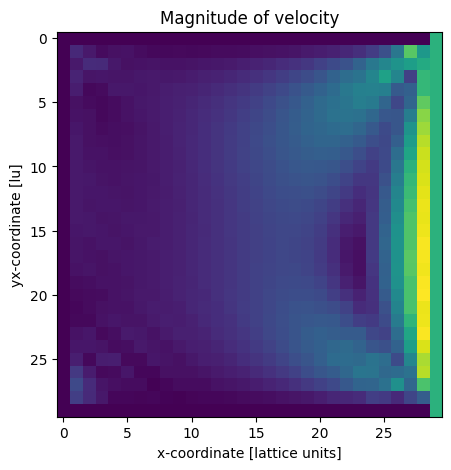

  0.638037 seconds (1.32 M allocations: 64.610 MiB, 2.38% gc time, 99.73% compilation time)
  1.549506 seconds (12.64 M allocations: 1.064 GiB, 5.60% gc time)


PyObject Text(23.999999999999993, 0.5, 'yx-coordinate [lu]')

In [97]:
problem  = LatticeState(Nx, Ny)
init!(problem)
@time step!(problem,   1) # Run simulation the first time to get rid of compilation overhead
@time step!(problem, 1000) # Run simulation (for real!)

u = @. sqrt(problem.ux^2 + problem.uy^2)
figure(figsize=(10,5))
imshow(problem.ρ); title("Density ρ")
#imshow(ψ'); title("ψ")
imshow(u); title("Magnitude of velocity")
xlabel("x-coordinate [lattice units]")
ylabel("yx-coordinate [lu]")

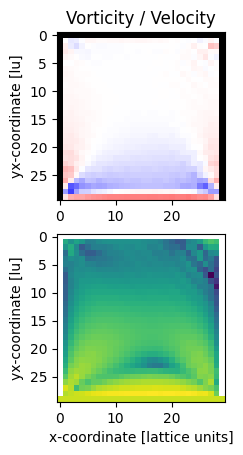

PyObject Text(23.999999999999993, 0.5, 'yx-coordinate [lu]')

In [98]:
ux = copy(problem.ux)
uy = copy(problem.uy)
velocity  = ux .^2 .+ uy .^ 2
vorticity = (circshift(ux, (0,+1)) .- circshift(ux, (0,-1))) .-
            (circshift(uy, (+1,0)) .- circshift(uy, (-1,0)))
vorticity[1,:] .= NaN
vorticity[:,1] .= NaN
vorticity[Nx,:].= NaN
bwr = PyPlot.cm.bwr.copy(); bwr.set_bad("black")

subplot(2,1,1); imshow(vorticity', cmap=bwr); clim([-.03, +.03]);
title("Vorticity / Velocity")
ylabel("yx-coordinate [lu]")
subplot(2,1,2); imshow(log10.(abs.(velocity')))
xlabel("x-coordinate [lattice units]")
ylabel("yx-coordinate [lu]")

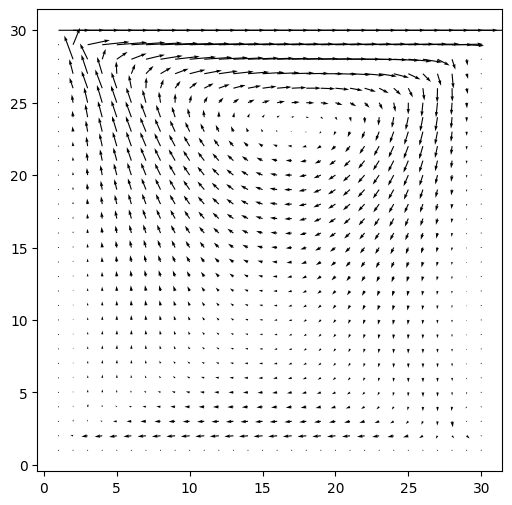

PyObject <matplotlib.quiver.Quiver object at 0x150d6b820>

In [85]:
figure(figsize=(6,6))
quiver([i for i=1:Nx, j=1:Ny], [j for i=1:Nx, j=1:Ny], problem.ux, problem.uy)